In [1]:
import numpy as np
import optuna
SEED = 42

import random
import tensorflow as tf
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

c:\Users\natha\Documents\Git\5th-year-polytech\deep_learning\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X_train, X_val, X_test = np.random.uniform(0, 1, 1000), np.random.uniform(0, 1, 200), np.random.uniform(0, 1, 200)
y_train, y_val, y_test = np.sin(8*np.pi*X_train), np.sin(8*np.pi*X_val), np.sin(8*np.pi*X_test)

In [3]:
from keras import layers, Sequential, Input
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

In [4]:
def create_model(n1 = 64, n2 = 64, n3 = 64, act = "relu", epochs = 300, learning_rate = 10**-3) :

    model = Sequential()
    model.add(Input(shape=(1, )))
    model.add(layers.Dense(n1, activation=act))
    model.add(layers.Dense(n2, activation=act))
    model.add(layers.Dense(n3, activation=act))
    model.add(layers.Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss = MeanSquaredError(), metrics = [MeanSquaredError()])
    history = model.fit(X_train, y_train, batch_size=128, epochs=epochs, validation_data=(X_val, y_val), verbose = 0)
    return model, history

In [5]:
model, history = create_model()
y_pred = model.predict(x = X_test)
print("Loss : ", np.mean(np.square(y_test - y_pred)))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Loss :  0.8096064001476292


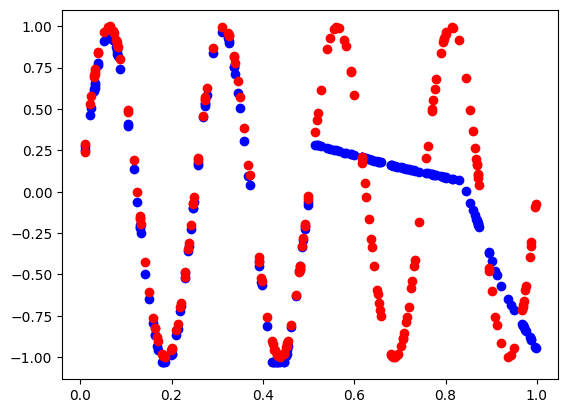

In [6]:
import matplotlib.pyplot as plt
plt.scatter(x = X_test, y = y_pred, color = "blue")
plt.scatter(x = X_test, y = y_test, color = "red")

In [7]:
def objectif(trial):
    n_unit1 = trial.suggest_int("unit1", 32, 64)
    n_unit2 = trial.suggest_int("unit2", 64, 128)
    n_unit3 = trial.suggest_int("unit3", 128, 256)
    learning_rate = trial.suggest_float("lr", 10**-4, 10**-1)
    activation = trial.suggest_categorical("activation", ["relu", "selu"])
    model, history = create_model(n_unit1, n_unit2, n_unit3, activation, epochs = 50, learning_rate=learning_rate)
    val_mse = history.history["val_mean_squared_error"][-1]
    return val_mse

study = optuna.create_study(direction = "minimize")
study.optimize(objectif, n_trials = 10)


[I 2025-09-10 12:07:59,540] A new study created in memory with name: no-name-f5f8794f-c451-4eac-a3ac-4e895216df76
[I 2025-09-10 12:08:03,957] Trial 0 finished with value: 0.9762959480285645 and parameters: {'unit1': 64, 'unit2': 80, 'unit3': 150, 'lr': 0.09949922311208563, 'activation': 'selu'}. Best is trial 0 with value: 0.9762959480285645.
[I 2025-09-10 12:08:08,278] Trial 1 finished with value: 0.47647005319595337 and parameters: {'unit1': 46, 'unit2': 65, 'unit3': 153, 'lr': 0.07360005171552844, 'activation': 'relu'}. Best is trial 1 with value: 0.47647005319595337.
[I 2025-09-10 12:08:12,537] Trial 2 finished with value: 0.47771310806274414 and parameters: {'unit1': 34, 'unit2': 122, 'unit3': 217, 'lr': 0.09611323729269858, 'activation': 'relu'}. Best is trial 1 with value: 0.47647005319595337.
[I 2025-09-10 12:08:16,742] Trial 3 finished with value: 0.4767289161682129 and parameters: {'unit1': 50, 'unit2': 113, 'unit3': 221, 'lr': 0.05952826974290925, 'activation': 'relu'}. Best

In [8]:
study.best_params

{'unit1': 55,
 'unit2': 95,
 'unit3': 137,
 'lr': 0.03799056334391324,
 'activation': 'relu'}